In [581]:
#Importing the necessary packages for preprocessing
import numpy as np
import pandas as pd
import alpha_vantage
import time
from sklearn.preprocessing import MinMaxScaler as mms
from alpha_vantage.timeseries import TimeSeries 
from alpha_vantage.techindicators import TechIndicators
from alpha_vantage.cryptocurrencies import CryptoCurrencies
#Symbols that represent each stock that will be used
symbols = ["IBM", "GOOG", "NFLX", "AMZN", "AAPL", "MSFT", "TSLA", "NVDA", "ADBE"]

In [8]:
#5 calls per minute, 500 per day -api call limits-
#Alpha vantage API is used to obtain the stock data
#getting the api key from separate file
key_file = open("key.txt", "r")
my_key = key_file.read()

ts = TimeSeries(key=my_key, output_format = "pandas")
ti = TechIndicators(key=my_key, output_format='pandas')

stock_dataframes = {}
#Getting the stock data for 9 different stocks from the api
#Retrieves basic information about the stock as well as the relevant technical indicators
for symbol in symbols:
    print(symbol)
    time.sleep(60)
    ts_data, ts_meta_data = ts.get_daily_adjusted(symbol, outputsize='full')
    
    ema_data, ema_meta_data = ti.get_ema(symbol, interval="daily")
    rsi_data, rsi_meta_data = ti.get_rsi(symbol, interval="daily")
    time.sleep(60)
    macd_data, macd_meta_data = ti.get_macd(symbol, interval="daily")
    bband_data, bband_meta_data = ti.get_bbands(symbol, interval="daily")
    ad_data, ad_meta_data = ti.get_ad(symbol, interval="daily")
    
    #removing unecessary features from the data
    stock_dataframes[symbol] = pd.concat([ts_data, ema_data, rsi_data, macd_data, bband_data, ad_data], axis=1, join="inner")
    stock_dataframes[symbol].drop(['1. open', '2. high', '3. low', '5. adjusted close', '7. dividend amount', '8. split coefficient'], axis=1, inplace=True)
    #Writing the data to the csv because using the api to get the stock data is a length process
    #Calling the api to retrieve the data is not preferred
    stock_dataframes[symbol].to_csv('StockData/' + symbol + '.csv')

IBM
GOOG
NFLX
AMZN
AAPL
MSFT
TSLA
NVDA
ADBE
INTC


In [431]:
#Code used to retrieve data from the csv that it has been previously written to
for symbol in symbols:
    stock_dataframes[symbol] = pd.read_csv('StockData/' + symbol + '.csv')
    stock_dataframes[symbol] = stock_dataframes[symbol].set_index('date')

In [432]:
#Normalizing the data for all stocks, then writing them to a csv
normalized_stock_dataframes = {}
for symbol in symbols:
    normalized_stock_dataframes[symbol] = (stock_dataframes[symbol]-stock_dataframes[symbol].min())/(stock_dataframes[symbol].max()-stock_dataframes[symbol].min())
    normalized_stock_dataframes[symbol].to_csv('NormalizedStockData/' + symbol + '.csv', index=True)
    normalized_stock_dataframes[symbol] = np.flipud(normalized_stock_dataframes[symbol])

In [433]:
train_data = {}
test_data = {}
train_split_size = 0.7
#Creating testing and training data sets for each stock
for symbol in symbols:
    train_size = int(len(normalized_stock_dataframes[symbol]) * train_split_size
    test_size = len(normalized_stock_dataframes[symbol]) - train_size
    train_data[symbol] = normalized_stock_dataframes[symbol][0:train_size]
    test_data[symbol] = normalized_stock_dataframes[symbol][train_size:-1]


In [440]:
X_train = {}
y_train = {}
X_test = {}
y_test = {}

n_past = 90
n_future = 5

#separating the datasets further into their respective inputs and outputs
#First the lists to hold the data are made, then the lists are converted to numpy
for symbol in symbols:
    X_train[symbol], y_train[symbol] = [], []
    X_test[symbol], y_test[symbol] = [], []
    if normalized_stock_dataframes[symbol] is type(stock_dataframes['IBM']):
        normalized_stock_dataframes[symbol] = normalized_stock_dataframes[symbol].to_numpy()
#The data is prepared in a special way because of its time series nature
#The input data is created using a window pane method where each index in the list holds the 'n_past' rows that come after it
#The output value is then the 'n_future'th row after the final row that is saved in the given index
for symbol in symbols:
    for i in range(n_past, len(train_data[symbol]) - n_future + 1):
        X_train[symbol].append(train_data[symbol][i - n_past: i, 0: train_data[symbol].shape[1]])
        y_train[symbol].append(train_data[symbol][i + n_future - 1:i + n_future, 0])
    for i in range(n_past, len(test_data[symbol]) - n_future + 1):
        X_test[symbol].append(test_data[symbol][i - n_past: i, 0: test_data[symbol].shape[1]])
        y_test[symbol].append(test_data[symbol][i + n_future - 1:i + n_future, 0])
    #data is converted to numpy
    X_train[symbol], y_train[symbol] = np.array(X_train[symbol]), np.array(y_train[symbol])
    X_test[symbol], y_test[symbol] = np.array(X_test[symbol]), np.array(y_test[symbol])

In [441]:
#importing necessary packages for creating and training the model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Activation
from tensorflow.python.keras.utils.generic_utils import get_custom_objects
from tensorflow.keras import backend as K
import pandas as pd
from matplotlib import pyplot as plt

In [576]:
#Special activation function that uses properties from the sigmoid and is meant to perform better than relu
def swish(x):
    return (K.sigmoid(x) * x)

get_custom_objects().update({'swish': Activation(swish)})

#Creating the model, which uses lstm nodes which are more suited to time series data
model = Sequential()
model.add(LSTM(16, activation='swish', input_shape=(X_train['IBM'].shape[1], X_train['IBM'].shape[2]), return_sequences=True))
model.add(LSTM(16, activation='swish', return_sequences=False))
model.add(Activation('tanh'))
model.add(Dropout(0.4))
model.add(Dense(y_train['IBM'].shape[1]))

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_93"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_183 (LSTM)              (None, 90, 16)            1792      
_________________________________________________________________
lstm_184 (LSTM)              (None, 16)                2112      
_________________________________________________________________
activation_123 (Activation)  (None, 16)                0         
_________________________________________________________________
dropout_89 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_90 (Dense)             (None, 1)                 17        
Total params: 3,921
Trainable params: 3,921
Non-trainable params: 0
_________________________________________________________________


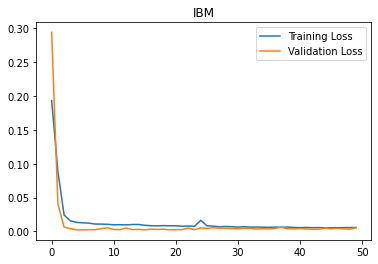

In [577]:
#Training the model on IBM Stock data
history = model.fit(X_train['IBM'], y_train['IBM'], epochs=50, batch_size=128, validation_split=0.30, verbose=0)
#Graphing the validation and training loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('IBM')
plt.legend()

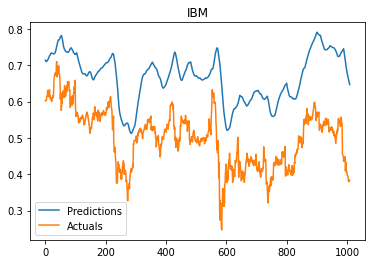

In [578]:
#Graphing the predicted values against the actual values
prediction = model.predict(X_test['IBM'])
plt.plot(prediction, label='Predictions')
plt.plot(y_test['IBM'], label='Actuals')
plt.title('IBM')
plt.legend()

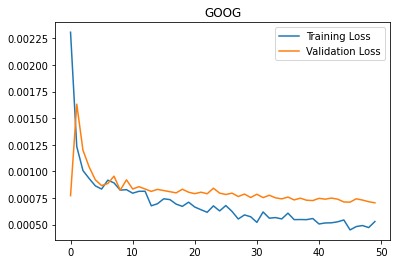

In [579]:
#Training the model on Google stock data
history = model.fit(X_train['GOOG'], y_train['GOOG'], epochs=50, batch_size=64, validation_split=0.30, verbose=0)
#Graphing the validation and training loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('GOOG')
plt.legend()

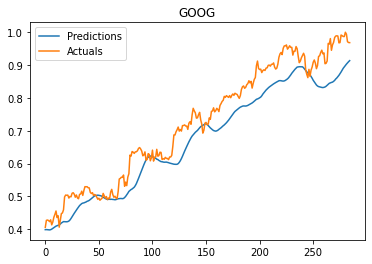

In [580]:
#Graphing the predicted values against the actual values
prediction = model.predict(X_test['GOOG'])
plt.plot(prediction, label='Predictions')
plt.plot(y_test['GOOG'], label='Actuals')
plt.title('GOOG')
plt.legend()

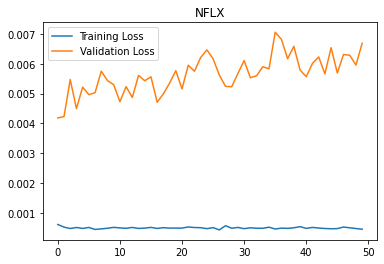

In [611]:
#Training the model on Netflix stock data
history = model.fit(X_train['NFLX'], y_train['NFLX'], epochs=50, batch_size=64, validation_split=0.30, verbose=0)
#Graphing the validation and training loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('NFLX')
plt.legend()

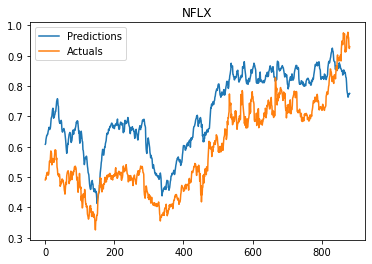

In [612]:
#Graphing the predicted values against the actual values
prediction = model.predict(X_test['NFLX'])
plt.plot(prediction, label='Predictions')
plt.plot(y_test['NFLX'], label='Actuals')
plt.title('NFLX')
plt.legend()

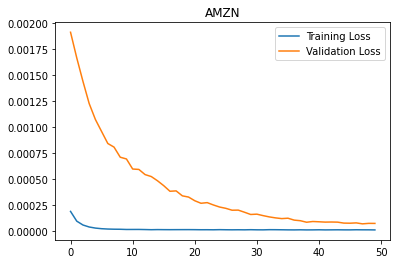

In [599]:
#Training the model on Amazon stock data
history = model.fit(X_train['AMZN'], y_train['AMZN'], epochs=50, batch_size=64, validation_split=0.30, verbose=0)
#Graphing the validation and training loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('AMZN')
plt.legend()

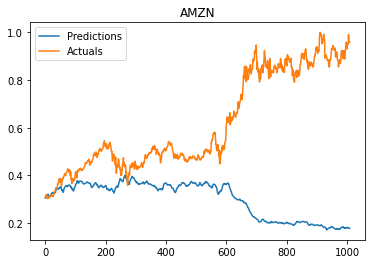

In [600]:
#Graphing the predicted values against the actual values
prediction = model.predict(X_test['AMZN'])
plt.plot(prediction, label='Predictions')
plt.plot(y_test['AMZN'], label='Actuals')
plt.title('AMZN')
plt.legend()

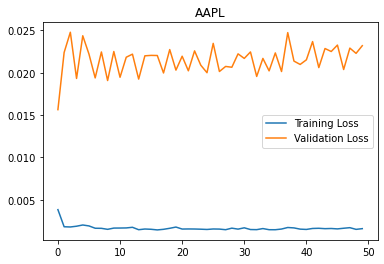

In [601]:
#Training the model on Apple stock data
history = model.fit(X_train['AAPL'], y_train['AAPL'], epochs=50, batch_size=64, validation_split=0.30, verbose=0)
#Graphing the validation and training loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('AAPL')
plt.legend()

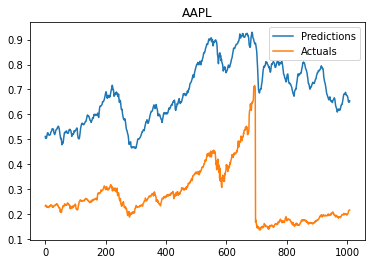

In [602]:
#Graphing the predicted values against the actual values
prediction = model.predict(X_test['AAPL'])
plt.plot(prediction, label='Predictions')
plt.plot(y_test['AAPL'], label='Actuals')
plt.title('AAPL')
plt.legend()

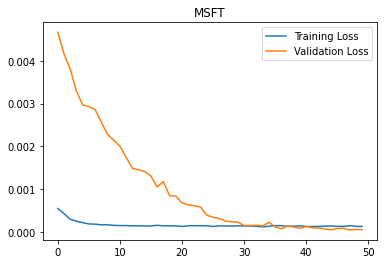

In [603]:
#Training the model on Microsoft stock data
history = model.fit(X_train['MSFT'], y_train['MSFT'], epochs=50, batch_size=64, validation_split=0.30, verbose=0)
#Graphing the validation and training loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('MSFT')
plt.legend()

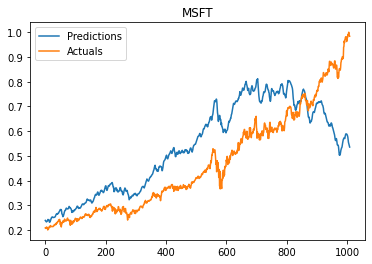

In [604]:
#Graphing the predicted values against the actual values
prediction = model.predict(X_test['MSFT'])
plt.plot(prediction, label='Predictions')
plt.plot(y_test['MSFT'], label='Actuals')
plt.title('MSFT')
plt.legend()

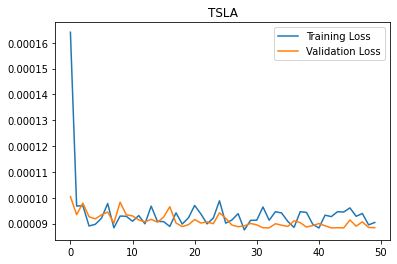

In [605]:
#Training the model on Tesla stock data
history = model.fit(X_train['TSLA'], y_train['TSLA'], epochs=50, batch_size=64, validation_split=0.30, verbose=0)
#Graphing the validation and training loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('TSLA')
plt.legend()

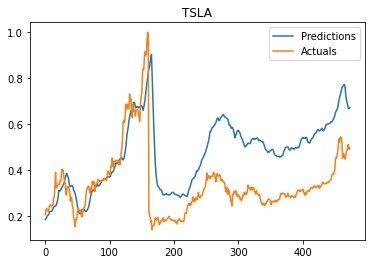

In [606]:
#Graphing the predicted values against the actual values
prediction = model.predict(X_test['TSLA'])
plt.plot(prediction, label='Predictions')
plt.plot(y_test['TSLA'], label='Actuals')
plt.title('TSLA')
plt.legend()

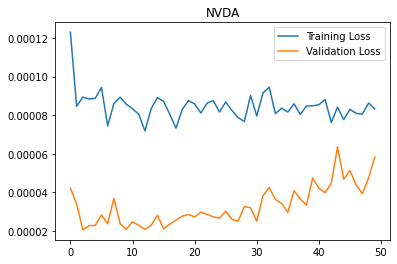

In [607]:
#Training the model on Nvidia stock data
history = model.fit(X_train['NVDA'], y_train['NVDA'], epochs=50, batch_size=64, validation_split=0.30, verbose=0)
#Graphing the validation and training loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('NVDA')
plt.legend()

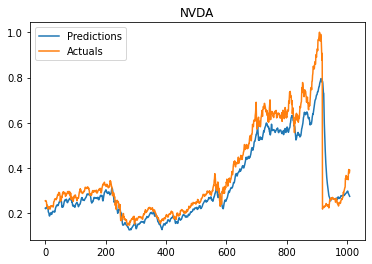

In [608]:
#Graphing the predicted values against the actual values
prediction = model.predict(X_test['NVDA'])
plt.plot(prediction, label='Predictions')
plt.plot(y_test['NVDA'], label='Actuals')
plt.title('NVDA')
plt.legend()

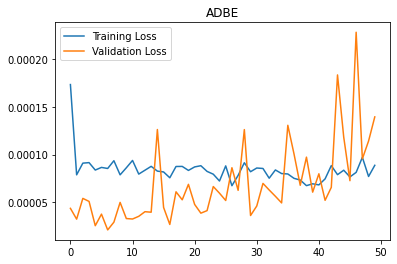

In [609]:
#Training the model on Adobe stock data
history = model.fit(X_train['ADBE'], y_train['ADBE'], epochs=50, batch_size=64, validation_split=0.30, verbose=0)
#Graphing the validation and training loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('ADBE')
plt.legend()

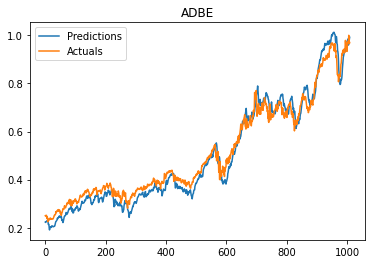

In [610]:
#Graphing the predicted values against the actual values
prediction = model.predict(X_test['ADBE'])
plt.plot(prediction, label='Predictions')
plt.plot(y_test['ADBE'], label='Actuals')
plt.title('ADBE')
plt.legend()